In [30]:
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pf

In [36]:
class System:
    def __init__(self,N=1024):
        self.N = N
        self.S = []
        self.I = []
        self.fS = cp.zeros((N,N))
        self.fI = cp.zeros((N,N))
        self.lambda_ = []
    
    def set_initial_conditions(self,S0,I0):
        self.S = S0
        self.I = I0
    
    def set_plane_initial_conditions(self,x0 = 1):
        self.S = cp.ones((self.N,self.N))
        self.I = cp.zeros((self.N,self.N))
        self.I[:,x0] = 1
        self.S[:,x0] = 0
    
    def set_dic_lambda(self,lambda0=.2,p=0):
        self.lambda_ = cp.random.choice([0,lambda0],size=(self.N,self.N),p = [p,1-p])
    
    def update(self,tstep=.1):
        pf.forces(self.S,self.I,self.lambda_,self.N,self.fS,self.fI)
        self.S += tstep*self.fS
        self.I += tstep*self.fI
    
    def solve(self,tmax=1000,tstep=.1):
        t = 0
        while self.u_cm() < self.N*.8 and t <= tmax:
            self.update(tstep)
            self.rigid_x()
            t += 1

    def rigid_x(self):
        self.S[:,0] = self.S[:,-1] = self.I[:,0] = self.I[:,-1] = 0
    
    def rigid_y(self):
        self.S[0,:] = self.S[-1,:] = self.I[0,:] = self.I[-1,:] = 0
    
    def u(self):
        return cp.argmax(self.I,axis=1)
    
    def u_cm(self):
        return cp.mean(self.u())
    
    def u_sigma(self):
        return cp.std(self.u())
    
    def u_fft(self):
        return cp.square(cp.abs(cp.fft.fft(self.u())))
    
    def f_I(self):
        return cp.roll(cp.mean(self.I,axis=0),int(-self.u_cm())+self.N//2)
    
    def mean_Ymax(self):
        return cp.mean(cp.max(self.I,axis=1))
    
    def plot_u(self):
        plt.matshow(cp.asnumpy(self.u()))

    def plot_I(self):
        plt.matshow(cp.asnumpy(self.I))
    
    def plot_S(self):
        plt.matshow(cp.asnumpy(self.S))
    
    

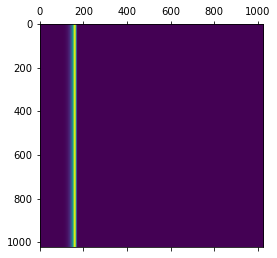

In [37]:
s = System(1024)
s.set_plane_initial_conditions()
s.set_dic_lambda(.2,0)

s.solve(1000)

s.plot_I()